# Perturbation Theory
<style type="text/css">
  .reveal p {
    text-align: left;
  }
  .reveal ul {
    display: block;
  }
  .reveal ol {
    display: block;
  }
</style>

# Linear Quadratic Dynamic Programing

## Setting Up The LQ Problem
* We'll start by studying and understanding a simple LQ Problem

* Consider an agent wanting to maximize
$$
    -\sum_{t=0}^\infty \beta^t\left(x_t'Rx_t+u_t'Qu_t\right)
$$
* Can also study problem with $\beta =1$

* Subject to the law of motion $x_{t+1} = Ax_t +Bu_t$ with $x_0$ given

* We'll approach this in two ways:
    
    1. Solve the bellman equation buy guessing a value function

    2. Stable Solutions: Focus on solutions that don't explode

* Both will arrive at the same solution

    * Second method will be faster and generalize


## Guessing the Value Function

* As this is a linear quadratic problem, it is natural to guess a solution that is quadratic
$$
V(x) = -x'Px
$$
where $P$ is positive semi-definite.

* The Bellman equation can then be written as 
$$
-x'Px = \max_{u} \left\{-x'Rx - u'Qu - \beta (Ax+Bu)'P(Ax+Bu)\right\}
$$

* We can take first order conditions with respect to $u$ to get
$$
u = -\underbrace{\beta\left(Q+\beta B'PB\right)^{-1}B'PA}_Fx
$$

* Plug this into the Bellman equation to get
$$
P = R + \beta A'PA - \beta^2 A'PB(Q+\beta B'PB)^{-1}B'PA
$$

## Solving the Bellman Equation
* One natural way to solve this Bellman Equation is through value function iteration

* Start with a guess $P_j$ and obtaing $P_{j+1}$ via
$$
P_{j+1} = R + \beta A'P_jA - \beta^2 A'P_jB(Q+\beta B'P_jB)^{-1}B'P_jA
$$

* Keep iterating until a fixed point is found

## Implementing the LQ Problem

In [24]:
using StatsPlots,Parameters,LinearAlgebra
default(linewidth=2,legend=false)
mutable struct LQProblem
    #Objective
    β::Float64
    R::Matrix{Float64}
    Q::Matrix{Float64}

    #Constraint
    A::Matrix{Float64}
    B::Matrix{Float64}

    #Solution
    P::Matrix{Float64}
    F::Matrix{Float64}
end;

## Solving The Ricatti Equation

In [2]:
"""
    iterate_ricatti(lq::LQProblem,P)    

Iterates on the Ricatti euqation given value function x'Px
"""
function iterate_ricatti(lq::LQProblem,P)
    @unpack β,R,Q,A,B = lq

    return R + β*A'*P*A - β^2*A'*P*B*inv(Q+B'*P*B)*B'*P*A
end

"""
    sovle_ricatti(lq)

Solves the Ricatti equation 
"""
function solve_ricatti!(lq)
    @unpack β,R,Q,A,B = lq
    P = copy(R)
    diff = 1.
    while diff>1e-8
        P′ =  iterate_ricatti(lq,P)
        diff = norm(P′-P,Inf)
        P = P′
    end

    lq.P = P
    lq.F = β*inv(Q+B'*P*B)*B'*P*A
end;

## Simulation

In [3]:
"""
    simulate_lq(lq,x0,T)

Simulates a solution to the LQ problem assuming lq.P and lq.F 
are already given.
"""
function simulate_lq(lq,x0,T)
    @unpack F,A,B = lq
    x = zeros(length(x0),T+1)
    u = zeros(size(F,1),T)

    x[:,1] = x0
    for t in 1:T
        u[:,t] = -F*x[:,t]
        x[:,t+1] = A*x[:,t] + B*u[:,t]
    end

    return (x=x,u=u)
end;

## An Example
* Consider the problem of a firm which wants to maximize profits
    * Depends how far price, $p_t$, is from target price, $\bar p_t$

    * Changing price requires paying price adjustment cost

*  Present value of profits given by
$$
    -\sum_{t=0}^\infty \beta^t\left(\gamma_1\left(p_t - \bar p_t\right)^2+\gamma_2\left(p_t-p_{t-1}\right)^2\right)
$$

* Assume that $\bar p_t$ has a persistance of $\rho$
$$
\bar p_t = \rho \bar p_{t-1}
$$

* Has to choose price one period in advance.  


## Writing in LQ form
* Our state is $x_t =[\bar p_t,p_t]$

* Our choice variable is $u_t = p_{t+1}-p_t$

* Given this setting the matrices of the LQ problem are given by
$$
R = \gamma_1\left[\begin{matrix}1 & -1\\-1&1\end{matrix}\right]\text{  and  } Q = [\gamma_2]
$$
and
$$
A = \left[\begin{matrix}\rho&0\\ 0&1\end{matrix}\right]\text{  and  }B = \left[\begin{matrix}0\\1 \end{matrix}\right]
$$

## Setting Up The Firm's Problem

In [4]:
"""
    pricingLQ(β,γ_1,γ_2,ρ)

Setup the LQ problem of a firm.
"""
function pricingLQ(β,γ_1,γ_2,ρ)
    R = γ_1 .* [1 -1;-1 1]
    Q = γ_2 .* ones(1,1)

    A = [ρ 0;0 1]
    B = [0. ;1. ][:,:]

    return LQProblem(β,R,Q,A,B,zeros(1,1),zeros(1,1))
end
lq = pricingLQ(1.,1.,2.,0.9);

## Response to An Increase in Prices
* How does a firm respond to a temporary increase in target price

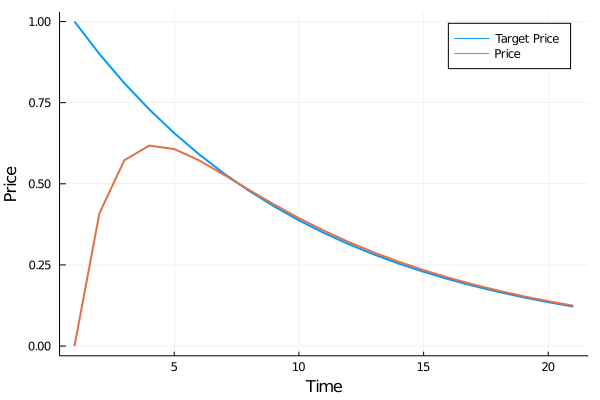

In [6]:
solve_ricatti!(lq)
x,u = simulate_lq(lq,[1.,0.],20)
plot(x[1,:],label="Target Price",legend=true)
plot!(x[2,:],label="Price",xlabel="Time",ylabel="Price")

# Certainty Equivilance
## LQ Problem with Uncertainty
* Suppose we adjust our problem to include uncertainty

* Planner chooses $u_t$ to maximize
$$
    -\mathbb E \sum_{t=0}^\infty \beta^t \left(x'_tRx_t +u'_tQu_t\right)
$$
subject to $x_0$ given and the law of motion
$$
x_{t+1} = A x_t + B u_t + C\epsilon_{t+1}
$$

* $\epsilon_{t+1}$ is i.i.d. with mean 0 and identity covariance.

* How does this change the problem?

## Certainty Equivilance
*  We'll guess that the value function takes the form $v(x)= -x'Px - d$

* Pluging into the Bellman equation we get
$$
v(x) = \max_{u} \left\{-x'Rx - u'Qu - \beta \mathbb E (Ax+Bu+C\epsilon)'P(Ax+Bu+C\epsilon) -\beta d \right\}
$$

* Taking expectations and using $\mathbb E \epsilon=0$ we get
$$
v(x) = \max_{u} \left\{-x'Rx - u'Qu - \beta (Ax+Bu)'P(Ax+Bu)+\beta\mathbb E\epsilon'C'PC\epsilon -\beta d \right\}
$$

* We can take first order conditions with respect to $u$ to get
$$
u = -\underbrace{\beta\left(Q+\beta B'PB\right)^{-1}B'PA}_Fx
$$

* Plug this into the Bellman equation to get $d = \beta(1-\beta)^{-1}\text{trace}(PCC')$ and
$$
P = R + \beta A'PA - \beta^2 A'PB(Q+\beta B'PB)^{-1}B'PA
$$


# Stable Solutions

## Introducing Shadow Prices
* Can rewrite the bellman equation as 
$$
-x_t'Px_t = \max_{u_t,x_{t+1}} \left\{-x_t'Rx_t - u_t'Qu_t - x_{t+1}'Px_{t+1}\right\}
$$
subject to
$$
x_{t+1} = A x_t + B u_t
$$
* Note this is the undiscounted problem $\beta=1$

* Letting $2\mu_{t+1}'$ be the Lagrange multiplier on the constraint

* First order condition with respect to $x_{t+1}$: $\mu_{t+1} =  P x_{t+1}$
    * Or $\mu_t =  P x_t$
    * We'll call $\mu_t$ the co-state since it moves 1-1 with $x_t$

* The envolope condition implies
$$
P x_t = R x_t + A'\mu_{t+1} \text{  or  }\mu_t = R x_t + A'\mu_{t+1}
$$

## A Sequence Problem
* We can solve the problem starting with the sequence problem

*  Construct the Lagrangian
$$
\mathcal L = -\sum_{t=0}^\infty \left(x_t'Rx_t +u_t'Qu_t +2\mu_{t+1}'[Ax_t + Bu_t -x_{t+1}]\right) 
$$

* First order conditions with respect to $u_{t}$ and $x_{t+1}$ imply
\begin{align}
0&=Q u_t + B'\mu_{t+1}\\
\mu_{t} &=  Rx_{t} +  A'\mu_{t+1} 
\end{align}

* Policy depends on the co-state via: $u_t = -Q^{-1}B'\mu_{t+1}$

## A System of equations

* Recall $x_{t+1} = A x_t + B u_t$   

* Stacking $x_t$ on $\mu_t$ we get
$$
    L\left(\begin{matrix}x_{t+1}\\ \mu_{t+1}\end{matrix}\right)=N\left(\begin{matrix}x_{t}\\ \mu_{t}\end{matrix}\right)
$$ 

* Where 
$$
    L = \left(\begin{matrix}I & B Q^{-1}B'\\0& A'\end{matrix}\right)\text{  and } N = \left(\begin{matrix}A & 0\\- R&I\end{matrix}\right)
$$

* Assuming $A$ is full rank we get 
$$
\left(\begin{matrix}x_{t+1}\\ \mu_{t+1}\end{matrix}\right)=M\left(\begin{matrix}x_{t}\\ \mu_{t}\end{matrix}\right)
$$
with $M = L^{-1}N$

## Stability As A Solution Approach
* Recall that $x_0$ is given
    * Given $\mu_0$ we can solve for the entire path $\mu_t,x_t$
    * Optimality gives terminal condition $\lim_{t\rightarrow\infty}x_t=0$
    * Should seem very similar to the shooting algroithm

In [7]:
"""
    simulate_costate(lq,x0,μ0,T)

Simulates the path of variables using the costate sytem.
Assumes no-discounting
"""
function simulate_costate(lq,x0,μ0,T)
    @unpack A,B,R,Q = lq
    L = [I B*inv(Q)*B'; 0*R A']
    N = [A 0*A; -R I]
    M = L\N

    y = zeros(2*length(x0),T+1)
    y[:,1] = [x0;μ0]
    for t in 1:T
        y[:,t+1] = M*y[:,t]
    end

    return y
end;

* Let's see what happens as we change $\mu_0$
    * Remember: $\mu_0=Px_0$ under the optimal policy

## Dependence on Co-state
* Let $y_t = \left(\begin{matrix}x_{t}\\ \mu_{t}\end{matrix}\right)$ and plot path for $\mu_0=Px_0-\epsilon,Px_0,Px_0+\epsilon$

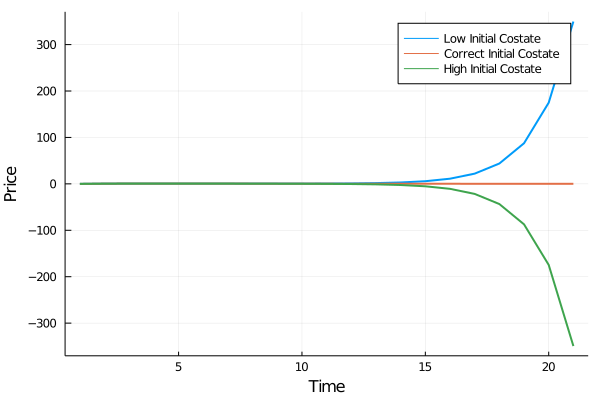

In [8]:
x0 = [1.,0.]
solve_ricatti!(lq)
y_low = simulate_costate(lq,x0,lq.P*x0 - 0.001*ones(2),20)
y_correct = simulate_costate(lq,x0,lq.P*x0,20)
y_high = simulate_costate(lq,x0,lq.P*x0 + 0.001*ones(2),20)
plot(y_low[2,:],label="Low Initial Costate",legend=true)
plot!(y_correct[2,:],label="Correct Initial Costate")
plot!(y_high[2,:],label="High Initial Costate",
     xlabel="Time",ylabel="Price")

## Simplectic
* Let 
$$
J = \left(\begin{matrix}0 & -I\\ I&0\end{matrix}\right)
$$

* A matrix is called *symplectic* if $MJM' = J$
    * We can verify that our $M$ is simplectic

In [9]:
@unpack A,B,R,Q = lq
L = [I B*inv(Q)*B'; 0*R A']
N = [A 0*A; -R I]
M = L\N
M*[zeros(2,2) -I;I zeros(2,2)]*M'

4×4 Matrix{Float64}:
 0.0  0.0  -1.0           0.0
 0.0  0.0   0.0          -1.0
 1.0  0.0  -4.38607e-17   0.0
 0.0  1.0   0.0           0.0

* Simplectic matrices have pairs of eigenvalues:
    * If $\lambda$ is an eigenvalue of $M$ then so is $\lambda^{-1}$

## Schur Decomposition
* We can exploit the Schur Decomposition to understand the stability properties of $M$

* Schur decomposition:
    * Unitary matrix $Z$ and upper triangular matrix $Z$ such that
$$
    M = ZTZ^{-1}
$$ 
* Eigenvalues of $M$ are the diagonals of $T$

* This implies that
$$
y_{t+1} = ZTZ^{-1}y_t
$$
or
$$
y_t = ZT^tZ^{-1}y_0
$$

## Schur Decomposition in Julia

In [10]:
using LinearAlgebra
F = schur(M)
F.Z

4×4 Matrix{Float64}:
 0.0   0.0       0.0       1.0
 0.0   0.707107  0.707107  0.0
 1.0   0.0       0.0       0.0
 0.0  -0.707107  0.707107  0.0

In [11]:
F.T

4×4 Matrix{Float64}:
 1.11111  0.785674  0.785674  -1.11111
 0.0      2.0       0.5       -1.06066
 0.0      0.0       0.5        0.353553
 0.0      0.0       0.0        0.9

* Compare to

In [12]:
println(eigvals(M))

[0.5, 0.9, 1.1111111111111112, 2.0]


## Ordering The Schur Decomposition
* Can write $T$ as (all are $n\times n$ matrices)
$$
    T = \left(\begin{matrix}T_{11}&T_{12}\\ 0 &T_{22}\end{matrix}\right)
$$

* Free to choose order of eigenvalues in $T$: half will be $>1$ and half will be $<1$
    
* Order such that 
    * $T_{22}$ has only unstable eigenvalues
    * $T_{11}$ has only stable eigenvalues

* Then 
$$
    y_t = Z\left(\begin{matrix}T_{11}^t&T_{12,t}\\ 0 &T_{22}^t\end{matrix}\right)Z^{-1} y_0
$$
with
$$
    T_{12,t} = T_{11}^{t-1}T_{12,t} + T_{12,t}T_{22}^{t-1}
$$

## A Unique Stable path
* Define $y^*_t = V^{-1}y_t$
$$
\left(\begin{matrix}y^*_{1,t}\\ y^*_{2,t}\end{matrix}\right) = \left(\begin{matrix}T_{11}^t&T_{12,t}\\ 0 &T_{22}^t\end{matrix}\right) \left(\begin{matrix}y^*_{1,0}\\ y^*_{2,0}\end{matrix}\right)
$$

* $T_{22}$ has all the explosive eigenvalues
    * Only way for $y_t^*$ to converge to $0$ is if $y_{2,0}=0$

* Let $Z^{ij}$ be the $(i,j)$ piece of the partitioned $Z^{-1}$ matrix
$$
    y^*_{2,t} = Z^{21}x_t + Z^{22}\mu_t
$$
* To obtain a stable path
$$
    \mu_0 = -(Z^{22})^{-1}Z^{21}x_0
$$
* Exploiting the definition of the inverse
$$
    \mu_0 = Z_{21}Z_{11}^{-1}x_0=P x_0
$$

## Implementation

In [13]:
"""
    solve_ricatti_stable!(lq)

Solves the Ricatti equation by finding the unique stable path.
"""
function solve_ricatti_stable!(lq)
    @unpack A,B,R,Q = lq
    n = size(A,1)
    L = [I B*inv(Q)*B'; 0*R A']
    N = [A 0*A; -R I]
    M = L\N

    F = schur(M)
    ordschur!(F,F.values .< 1) #stack stable eigenvalues first

    Z = F.Z
    Z_11 = Z[1:n,1:n]
    Z_21 = Z[n+1:end,1:n]
    lq.P = P =  Z_21*inv(Z_11)
    lq.F = inv(Q+B'*P*B)*B'*P*A
end;

## Checking

In [14]:
solve_ricatti!(lq)
lq.P

2×2 Matrix{Float64}:
  1.73989  -1.81818
 -1.81818   2.0

In [15]:
solve_ricatti_stable!(lq)
lq.P

2×2 Matrix{Float64}:
  1.73989  -1.81818
 -1.81818   2.0

# Perturbation Theory
## General specification
* Want: a tool to approximate equilibria for a general model

* Let $x_t$ be predtermined variables
    * e.g. capital, past prices, customer base, etc.

* Let $y_t$ be the jump/choice variables
    * e.g. consumption, inflation, etc.
    * forward looking

* Let $\varepsilon_t$ be shocks (think i.i.d. normal)

* Equilibrium conditions are expressed in the following form
$$
\mathbb E_t\left[F(x_{t-1},x_t,y_t,y_{t+1},\epsilon_t) \right]
$$
* Only $y_{t+1}$ is unknown at time $t$

## Example
* Consider the following RBC model:
$$
    \max_{c_t,n_t}\mathbb E_0\sum_{t=0}^\infty \beta^t U(c_t,1-n_t)
$$
subject to 
\begin{align}
    c_t + k_{t+1} &= \exp(z_t)k_t^\alpha l_t^{1-\alpha}\\
    z_t &= \rho z_{t-1} + \epsilon_t
\end{align}

* Let $x_t = (k_t,z_t)$ and $y_t = (c_t,n_t,R_t)$; $F$ defined by:
$$
\mathbb E_t\left[\begin{matrix} c_t + k_{t+1} - \exp(z_t)k_t^\alpha l_t^{1-\alpha}\\
                                -U_l(c_t,1-n_t) - (1-\alpha)\exp(z_t)k_t^\alpha l_t^{1-\alpha}U_c(c_t,1-n_t)\\
                                U_c(c_t,1-n_t) - \beta R_{t+1}U_c(c_{t+1},1-n_{t+1})\\
                                R_{t} - \alpha \exp(z_t)k_t^{\alpha-1} l_t^{1-\alpha}\\
                                z_t - \rho z_{t-1} - \epsilon_t
                                \end{matrix}\right]=0
$$
 
## Equilibrium Objects
* Start with 
$$
\mathbb E_t\left[F(x_{t-1},x_t,y_t,y_{t+1},\epsilon_t) \right]
$$

* Want to find functions $g(x_{t-1},\epsilon_t)$ and $h(x_{t-1},\epsilon_t)$ such that 
\begin{align}
    x_t &= g(x_{t-1},\epsilon_t)\\
    y_t &= h(x_{t-1},\epsilon_t)
\end{align}

* Satisfies the equlibrium conditions:
$$
\mathbb E_t\left[F(x_{t-1},g(x_{t-1},\epsilon_t),h(x_{t-1},\epsilon_t),h(g(x_{t-1},\epsilon_t),\epsilon_{t+1}),\epsilon_t) \right]
$$

## A Steady State
* Idea: let $\epsilon_t = \sigma \eta_t$ where $\eta_t$ has variance 1

* Functions now given by
\begin{align}
    x_t &= g(x_{t-1},\sigma \eta_t;\sigma)\\
    y_t &= h(x_{t-1},\sigma \eta_t;\sigma)
\end{align}

* We know how to solve the model when $\sigma=0$: find steady state $\bar x$ and $\bar y$ satisfies
\begin{align}
    \bar x &= g(\bar x,0;0)\\
    \bar y &= h(\bar x,0;0)
\end{align}

## A Sigma Expansion
* Can approximate policies nearby steady state via taylor expansion
\begin{align}
    x_t &\approx \bar x + g_x(\bar x,0;0)(x_{t-1}-\bar x)+g_\varepsilon(\bar x,0;0)\sigma\eta_t+g_\epsilon(\bar x,0;0)\sigma\eta_t+g_\sigma(\bar x,0;0)\sigma\\
        &\approx \bar x + \bar g_x\hat x_{t-1} + \bar g_\varepsilon\sigma\eta_t + \bar g_\sigma\sigma
\end{align}
where $\hat x_{t-1} = (x_{t-1}-\bar x)$

* Similarly,
$$
    y_t \approx \bar y + \bar h_x \hat x_{t-1} +\bar h_\varepsilon\sigma\eta_t + \bar h_\sigma\sigma
$$

* A second order approximation would yield
$$
    x_t \approx \bar x + \bar g_x\hat x_{t-1} + \bar g_\varepsilon\sigma\eta_t + \bar g_\sigma\sigma +\frac{1}{2}\left(\hat x_{t-1}'\bar g_{xx}\hat x_{t-1} + \hat x_{t-1}'\bar g_{x\varepsilon}\sigma\eta_t+\sigma\eta_t'\bar g_{\varepsilon x}\hat x_{t-1}+\sigma\eta_t'\bar g_{\varepsilon\varepsilon}\sigma\eta_t+\bar g_{\sigma\sigma}\sigma^2\right)
$$

* How do we compute these derivatives?
    * The Implicit Function Theorem!

## Applying the IFT
* Start with
$$
\mathbb E_t\left[F(x_{t-1},g(x_{t-1},\sigma\eta_t;\sigma),h(x_{t-1},\sigma\eta_t;\sigma),h(g(x_{t-1},\sigma\eta_t;\sigma),\sigma\eta_t;\sigma),\sigma\eta_t) \right]
$$
* Differentiate with respect to $x$ at $\sigma=0$ to get
$$
\bar F_{x-} + \bar F_{x}\bar g_x +\bar F_y \bar h_x +\bar F_{y+}\bar h_x \bar g_x =0
$$
* $\bar F_x$ denotes derivative evaluated $(\bar x,\bar x,\bar y,\bar y)$

* Problem $\bar h_x \bar g_x$ enters quadratically
    * How do we find a solution?
    * Use stability!

## Using stability
* Star with a world without shocks:
    * $\hat x_t = \bar g_x \hat x_{t-1}$
    * $\hat y_t = \bar h_x \hat x_{t-1}$

* Multiply by $\hat x_{t-1}$ to get
$$
    \bar F_{x-}\hat x_{t-1} + \bar F_{x}\hat x_t +\bar F_y\hat y_t +\bar F_{y+}\hat y_{t+1} =0
$$
* Find stable solution of this sytem

* Let $\hat w_t =\left(\begin{matrix}\hat x_{t-1}\\ \hat y_t\end{matrix}\right)$ then this can be written as
$$
    G\hat w_{t+1} = A\hat w_{t}
$$

* This is familiar, we know how to solve this if $G^{-1}$ exists (can't guarantee this)

## Generalized Schur Decomposition (QZ decomposition)
* Given square matrices $G$ and $A$ there exists
    * Unitary matrices $Q$ and $Z$
    * Upper triangular  $T$ and $S$ 
$$
    G = QTZ^{-1} \text{  and  } A = QSZ^{-1}
$$

* Order and partition into blocks
$$
    T = \left[\begin{matrix} T_{\theta\theta}&T_{\theta\delta}\\ 0&T_{\delta\delta}\end{matrix}\right]\text{  and  }S = \left[\begin{matrix} S_{\theta\theta}&S_{\theta\delta}\\ 0&S_{\delta\delta}\end{matrix}\right]
$$

* Such that 
$$
\frac{\text{diag}(S_{\delta\delta})}{\text{diag}(T_{\delta\delta})}>1
$$

## Stable Solutions
* Plugging in for $G$ and $A$ we have
$$
    QTZ^{-1}\hat w_{t+1} = QS Z^{-1}\hat w_t
$$

* Define 
$$
    \left(\begin{matrix}\theta_t\\ \delta_t\end{matrix}\right)=Z^{-1}\hat w_t
$$
were we have partitioned $\theta_t$ and $\delta_t$ in line with to our ordering of $T$ and $S$

* The we get
$$
\left[\begin{matrix} T_{\theta\theta}&T_{\theta\delta}\\ 0&T_{\delta\delta}\end{matrix}\right]\left(\begin{matrix}\theta_{t+1}\\ \delta_{t+1}\end{matrix}\right) = \left[\begin{matrix} S_{\theta\theta}&S_{\theta\delta}\\ 0&S_{\delta\delta}\end{matrix}\right]\left(\begin{matrix}\theta_t\\ \delta_t\end{matrix}\right)
$$

## Stable Solutions Continued
*  By construction none of the eigenvalues of $S_{\delta\delta}$ are 0 so we can invert it
$$
S_{\delta\delta}^{-1}T_{\delta\delta}\delta_{t+1} = \delta_t
$$

* Or 
$$
\left(S_{\delta\delta}^{-1}T_{\delta\delta}\right)^n\delta_{t+n} = \delta_t
$$

*  By construction $\text{eig}\left(S_{\delta\delta}^{-1}T_{\delta\delta}\right)$<1
    * implies $\text{eig}\left(S_{\delta\delta}^{-1}T_{\delta\delta}\right)^n\rightarrow0$
    * implies $\delta_{t+n}\rightarrow\infty$ unless $\delta_t=0$

* Conclude that only stable paths have $\delta_t=0$ for all t

## Backing Out Policy Rules
* $\delta_t$ equlals zero implies that $x_{t-1}$ and $y_t$ must satisfy
$$
    \left[\begin{matrix}\theta_t\\ 0\end{matrix}\right]=Z^{-1}\left[\begin{matrix}x_{t-1}\\ y_{t}\end{matrix}\right]
$$
    * $x_{t-1}$ is predetermined so only $y_t$ can adjust

* Partition $Z$ into 
$$
Z = \left[\begin{matrix}Z_{x\theta}&Z_{x\delta}\\ Z_{y\theta}& Z_{y\delta}\end{matrix}\right]
$$
* Then 
$$
    \left[\begin{matrix}Z_{x\theta}\theta_t\\ Z_{y\theta}\theta_t\end{matrix}\right]=\left[\begin{matrix}x_{t-1}\\ y_{t}\end{matrix}\right]
$$

## Local Determinacy and Existence of Equilibria
Count $n_y$ and $n_\delta$ and three possibilities emerge

1. $n_y = n_\delta$ implies number of jump variables equals number of explosive eigenvalues
    * implies $n_x=n_\theta$ so $Z_{x\theta}$ is square and 
    * $\hat y_t = Z_{y\theta}Z_{x\theta}^{-1}\hat x_{t-1}$
    * equilibrium is locally unique

2. $n_y > n_\delta$ implies number of jump variables greater than number of explosive eigenvalues
    * multiple $y_t$ can set $\delta_t=0$
    * equilibrium exists but is indeterminate

3. $n_y < n_\delta$ implies number of jump variables less than number of explosive eigenvalues
    * generically cannot set $\delta_t=0$
    * equilibrium does not exist

## Computing Derivatives
* Focus on $n_y=n_\delta$ case

* We've shown that $\hat y_t = Z_{y\theta}Z_{x\theta}^{-1}\hat x_{t-1}$ and therefore
$$ 
    \bar h_x = Z_{y\theta}Z_{x\theta}^{-1}
$$

* $T_{\theta\theta}\theta_{t+1}=S_{\theta\theta}\theta_t$ implies
$$
    \bar g_x = Z_{x\theta}T_{\theta\theta}^{-1}S_{\theta\theta}Z_{x\theta}^{-1}
$$

## Computing Derivatives Shocks
* Differentiating $F$ with respect to $\sigma$ yields
\begin{align}
0 =& \bar F_x \bar g_\varepsilon +\bar F_y \bar h_\varepsilon + \bar F_{y+}\bar h_x\bar g_\varepsilon +\bar F_\varepsilon\\
0 =& \bar F_{x-}\bar g_\sigma + F_{x-}\bar g_\sigma + \bar F_y \bar h_\sigma  + \bar F_{y+}\left(\bar h_x\bar g_\sigma + \bar h_\sigma\right)
\end{align}
* First set of equations gives
$$
    \left[\begin{matrix}\bar g_\varepsilon\\ \bar h_\varepsilon\end{matrix}\right]=-\left[\begin{matrix}\bar F_x+\bar F_{y+}\bar h_x&\bar F_y\end{matrix}\right]^{-1}\bar F_\varepsilon
$$

* Second set of equations implies $\bar g_\sigma=\bar h_\sigma =0$
    * certainty equivilance


## Example
* Return to our familiar RBC model with productivity shocks
$$
\begin{aligned}
    c_t^{-\sigma} &= \beta R_{t+1}c_{t+1}^{-\sigma}\\
    R_t &=\alpha A_t k_t^{\alpha -1} + 1 - \delta\\
    c_t + k_{t+1} &= A_t k_t^\alpha +(1-\delta) k_t\\
    a_t &= \rho a_{t-1}+\sigma_\epsilon\varepsilon_t  
\end{aligned}
$$
where $A_t = \exp(a_t)$.  
* Need to classify variables as predetermined and jump 
    * $x_{t-1} = [a_{t-1},k_{t-1}]$
    * $y_t = [c_t,R_t]$

## Construct Model

In [16]:
using Parameters
@with_kw mutable struct RBCModel
    α::Float64 = 0.3 #Capital Share of Output
    β::Float64 = 0.96 #Discount Factor
    δ::Float64 = 0.1 #Depreciation Rate
    σ::Float64 = 2.  #1/IES
    ρ::Float64 = 0.85 #persistence of log productivity
    σ_ε::Float64 = 0.015 #innovation to log productivity

    #Store first order Approximation
    ḡ_x::Matrix{Float64} = zeros(0,0)
    ḡ_ε::Matrix{Float64} = zeros(0,0)

    h̄_x::Matrix{Float64} = zeros(0,0)
    h̄_ε::Matrix{Float64} = zeros(0,0)
end;

## Steady State
* Same steady state code as before, but we'll return $\bar x$ and $\bar y$

In [17]:
"""
    compute_steadystate(model::RBCModel)

Computes steady state given parameters stored in para
"""
function compute_steadystate(model::RBCModel)
    @unpack α,β,δ,σ = model
    R̄ = 1/β
    k̄ =((R̄ - 1 + δ)/(α))^(1/(α-1))

    c̄ = k̄^α - δ*k̄

    x̄ = [0,k̄]
    ȳ = [c̄,R̄]
    return x̄,ȳ,zeros(1)
end;

## The F Function
* Finally we need our $F$ function which defines equilibrium

In [18]:
"""
    F_RBC(model::RBCModel,x_,x,y,y′)

Equations governing the RBC model
"""
function F_RBC(model::RBCModel,x_,x,y,y′,ε)
    @unpack α,β,δ,σ,ρ = model
    #unpack variables
    a_,k_ = x_
    a,k = x
    c,R = y
    c′,R′ = y′
    A = exp(a)
    #return equations
    return[ c + k - A*k_^α - (1-δ)*k_,
            R - α*A*k_^(α-1) - 1 + δ,
            β*R′*(c′)^(-σ) - c^(-σ),
            a - ρ*a_ - ε[1]] #allowing ε to be a vector
end;

## Computing Derivatives
* How do we get $\bar F_x$ etc?  Do we have to do it by hand?
    * No! Use automatic differentiation

In [19]:
using ForwardDiff
model = RBCModel()
x̄,ȳ,ε̄ = compute_steadystate(model)
F̄_ε = ForwardDiff.jacobian(ε->F_RBC(model,x̄,x̄,ȳ,ȳ,ε),ε̄)
F̄_x_ = ForwardDiff.jacobian(x_->F_RBC(model,x_,x̄,ȳ,ȳ,ε̄),x̄)
F̄_x = ForwardDiff.jacobian(x->F_RBC(model,x̄,x,ȳ,ȳ,ε̄),x̄)
F̄_y = ForwardDiff.jacobian(y->F_RBC(model,x̄,x̄,y,ȳ,ε̄),ȳ)
F̄_y′ = ForwardDiff.jacobian(y′->F_RBC(model,x̄,x̄,ȳ,y′,ε̄),ȳ)

4×2 Matrix{Float64}:
  0.0      0.0
  0.0      0.0
 -1.55635  0.812188
  0.0      0.0

## Linearizing with Respect to the State

In [20]:
"""
    compute_dx(model,F,x̄,ȳ,ε̄)

Computes derivatives w.r.t. x of law of motion g and 
and policy rules h.
"""
function compute_dx!(model,F,x̄,ȳ,ε̄)
    nx = length(x̄)
    ny = length(ȳ)
    F̄_x_ = ForwardDiff.jacobian(x_->F(model,x_,x̄,ȳ,ȳ,ε̄),x̄)
    F̄_x = ForwardDiff.jacobian(x->F(model,x̄,x,ȳ,ȳ,ε̄),x̄)
    F̄_y = ForwardDiff.jacobian(y->F(model,x̄,x̄,y,ȳ,ε̄),ȳ)
    F̄_y′ = ForwardDiff.jacobian(y′->F(model,x̄,x̄,ȳ,y′,ε̄),ȳ)

    #G and A matrices
    G = [F̄_x F̄_y′]
    A = -[F̄_x_ F̄_y]

    F = schur(A,G) #generalized schur decomposition
    λ = abs.(F.α./F.β) #compute ratio of eigenvalues
    if sum(λ .> 1) > length(ȳ)
        error("Equlibrium does not exist")
    end
    if sum(λ .> 1) < length(ȳ)
        error("Equilibrium is not unique")
    end
    ordschur!(F,λ.<=1) #Put stable eigenvectors first
    Zxθ = F.Z[1:nx,1:nx]
    Zyθ = F.Z[nx+1:end,1:nx]
    Sθθ = F.S[1:nx,1:nx]
    Tθθ = F.T[1:nx,1:nx]
    
    model.h̄_x = Zyθ*inv(Zxθ)
    model.ḡ_x = Zxθ*inv(Tθθ)*Sθθ*inv(Zxθ)
end;
compute_dx!(model,F_RBC,x̄,ȳ,ε̄)
#check: should be all 0
F̄_x_ + F̄_x*model.ḡ_x+F̄_y*model.h̄_x+F̄_y′*model.h̄_x*model.ḡ_x

4×2 Matrix{Float64}:
 1.66533e-16   2.77556e-17
 4.16334e-17  -4.85723e-17
 1.11022e-16   8.32667e-17
 2.22045e-16   0.0

## Linearizing with Respect to the Shock

In [21]:
"""
    compute_dε!(model,F,x̄,ȳ,ε̄)

Computes derivatives w.r.t. ε of law of motion g and 
and policy rules h.
"""
function compute_dε!(model,F,x̄,ȳ,ε̄)
    @unpack h̄_x = model
    nx = length(x̄)
    ny = length(ȳ)
    F̄_ε = ForwardDiff.jacobian(ε->F(model,x̄,x̄,ȳ,ȳ,ε),ε̄)
    F̄_x = ForwardDiff.jacobian(x->F(model,x̄,x,ȳ,ȳ,ε̄),x̄)
    F̄_y = ForwardDiff.jacobian(y->F(model,x̄,x̄,y,ȳ,ε̄),ȳ)
    F̄_y′ = ForwardDiff.jacobian(y′->F(model,x̄,x̄,ȳ,y′,ε̄),ȳ)

    #G and A matrices
    dw_ε = -inv([F̄_x+F̄_y′*h̄_x F̄_y])*F̄_ε
    model.ḡ_ε = dw_ε[1:nx,:]
    model.h̄_ε = dw_ε[nx+1:end,:]
end
compute_dε!(model,F_RBC,x̄,ȳ,ε̄);

## Simulate an IRF

In [25]:
using DataFrames
"""
    compute_irf_RBC(model,T)

Computes the IRF to a 1 standard deviation shock to productivity
"""
function compute_irf_RBC(model,T)
    @unpack ḡ_x,ḡ_ε,h̄_x,h̄_ε,σ_ε = model
    nx = size(ḡ_x,1)
    ny = size(h̄_x,1)

    x = zeros(nx,T+1)
    y = zeros(ny,T)
    y[:,1] = h̄_ε*σ_ε
    x[:,2] = ḡ_ε*σ_ε
    for t in 2:T
        y[:,t] = h̄_x*x[:,t]
        x[:,t+1] = ḡ_x*x[:,t]
    end

    return DataFrame(t=1:T,c=y[1,:],R=y[2,:],a_=x[1,1:T],k_=x[2,1:T])
end;

## IRF to A One Time Productivity Shock

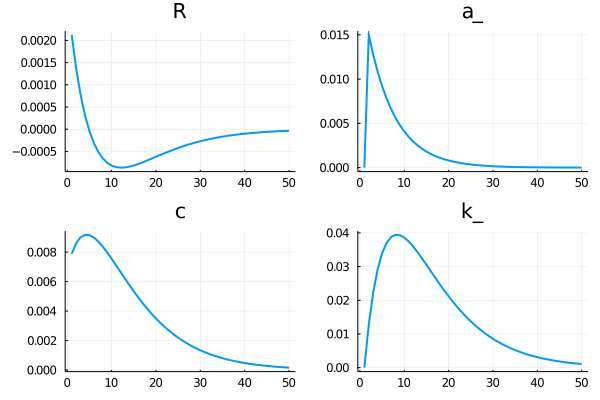

In [30]:
df = compute_irf_RBC(model,50)
@df df plot(:t,[:R,:a_,:c,:k_],layout=4,title=["R" "a_" "c" "k_"])

## Simulation

In [33]:
"""
    simulate_RBC(model,T)

Simulates the path of endogeneous variables for T periods
"""
function simulate_RBC(model,T)
    @unpack ḡ_x,ḡ_ε,h̄_x,h̄_ε,σ_ε = model
    nx = size(ḡ_x,1)
    ny = size(h̄_x,1)

    x = zeros(nx,T+1)
    y = zeros(ny,T)
    ε = randn(T)
    y[:,1] = h̄_ε*σ_ε*ε[1]
    x[:,2] = ḡ_ε*σ_ε*ε[1]
    for t in 2:T
        y[:,t] = h̄_x*x[:,t] + h̄_ε*σ_ε*ε[t]
        x[:,t+1] = ḡ_x*x[:,t] + ḡ_ε*σ_ε*ε[t]
    end

    return DataFrame(t=1:T,c=y[1,:],R=y[2,:],a_=x[1,1:T],k_=x[2,1:T],ε=ε)
end;

## Simulating 200 Periods

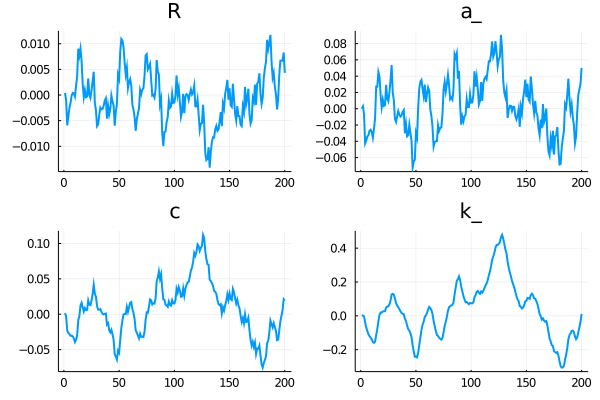

In [34]:
df = simulate_RBC(model,200)
@df df plot(:t,[:R,:a_,:c,:k_],layout=4,title=["R" "a_" "c" "k_"])

# Sequence Space Linearization
## An Alternative Linearization
* Is there another way to linearize the model?

* Yes: the analogue of solving perfect foresight model in sequence space

* Suppose that $\hat x_{-1}=0$ and there is a one time shock $\varepsilon_0$ 
    * All the other shocks will drop out in expectation

* Let $\hat x_t$ be the resulting path
    * Search for stable solution: assume $\hat x_t=\hat y_t=0$ for all $t\geq T$

* Write out the sytem of equations that $\hat x_t,\hat y_t$ solves

## System of Equations 

* At time 0: $\hat x_{-1}=0$
$$
    \bar F_x \hat x_0 +\bar F_y \hat y_0 +\bar F_{y'}\hat y_1 +\bar F_\varepsilon\varepsilon_0 =0
$$
* At time $1<t<T-1$:
$$
    \bar F_{x\_}\hat x_{t-1}+\bar F_x \hat x_t +\bar F_y \hat y_t +\bar F_{y'}\hat y_{t+1}=0
$$
* At time $t=T-1$: $\hat y_{T}=0$
$$
    \bar F_{x\_}\hat x_{T-2}+\bar F_x \hat x_{T-1} +\bar F_y \hat y_{T-1}=0
$$

## Stacking Equations
* Stack together to form one linear equation
$$
J\left[\begin{matrix}\hat x_0\\ \hat y_0\\ \hat x_1\\ \hat y_1\\ \vdots\\ \hat x_{T-1}\\ \hat y_{T-1}\end{matrix}\right]=A\epsilon_0
$$

## Linearizing Using the Sequence Space

In [35]:
"""
    linearize_sequence(model,F,x̄,ȳ,ε̄,T=100)

Linearizes the model using sequence space rather than schur decomposition
"""
function linearize_sequence(model,F,x̄,ȳ,ε̄,T=100)
    nx = length(x̄)
    ny = length(ȳ)
    F̄_x_ = ForwardDiff.jacobian(x_->F(model,x_,x̄,ȳ,ȳ,ε̄),x̄)
    F̄_x = ForwardDiff.jacobian(x->F(model,x̄,x,ȳ,ȳ,ε̄),x̄)
    F̄_y = ForwardDiff.jacobian(y->F(model,x̄,x̄,y,ȳ,ε̄),ȳ)
    F̄_y′ = ForwardDiff.jacobian(y′->F(model,x̄,x̄,ȳ,y′,ε̄),ȳ)
    F̄_ε = ForwardDiff.jacobian(ε->F(model,x̄,x̄,ȳ,ȳ,ε),ε̄)

    J = zeros(nx+ny,T,nx+ny,T)
    A = zeros(nx+ny,T)
    #setup for t=0
    A[:,1] = F̄_ε
    J[:,1,:,1] = [F̄_x F̄_y]
    J[:,1,nx+1:end,2] =  F̄_y′
    for t in 2:T-1
        J[:,t,1:nx,t-1] = F̄_x_ 
        J[:,t,:,t] = [F̄_x F̄_y]
        J[:,t,nx+1:end,t+1] =  F̄_y′
    end
    J[:,T,1:nx,T-1] = F̄_x_ 
    J[:,T,:,T] = [F̄_x F̄_y]

    J = reshape(J,(nx+ny)*(T),:)
    A = A[:]

    return reshape(-inv(J)*A,:,T)
end;

## Comparing IRFS T = 100

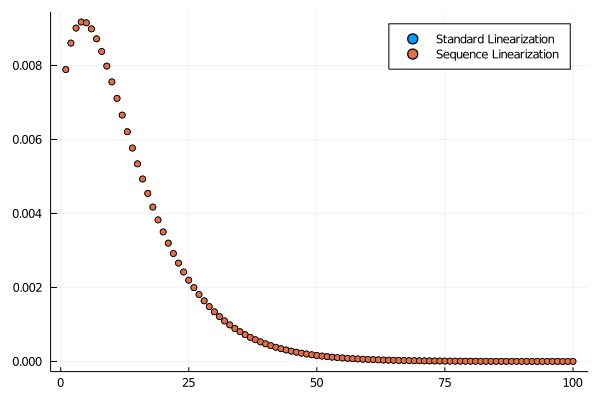

In [37]:
df_irf = compute_irf_RBC(model,100)
w = linearize_sequence(model,F_RBC,x̄,ȳ,ε̄)
@df df_irf scatter(:t,:c,label="Standard Linearization",legend=true)
scatter!(w[3,:]*model.σ_ε,label="Sequence Linearization")

## Comparing IRFS T = 25

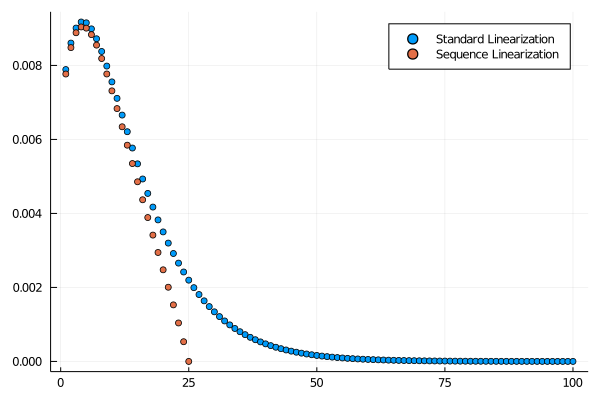

In [38]:
df = compute_irf_RBC(model,25)
w = linearize_sequence(model,F_RBC,x̄,ȳ,ε̄,25)
@df df_irf scatter(:t,:c,label="Standard Linearization",legend=true)
scatter!(w[3,:]*model.σ_ε,label="Sequence Linearization")

## Simulation 
* Straightforward to simulate using sequence space solution:
    * Have computed $\bar x_{\varepsilon,t}$ and $\bar y_{\varepsilon,t}$
    * Response of $x$ and $y$ to a shock t periods in the past

* Given a sequence of shocks $\varepsilon_t$ first order path of $\hat y_t$ given by
$$
    \hat y_t = \sum_{j=0}^T \bar x_{\varepsilon,j}\varepsilon_{t-j}
$$

* Equivalent approach: 
    * Start with $\hat y_t =0$ for all $t$
    * For $t= 1,\ldots$ add up impulse responses
    $$
        \hat y_{t+j} = \hat y_{t+j} + \sum_{j=0}^T \bar y_{\varepsilon,j}\varepsilon_t
    $$

## Implementing Simulation

In [44]:
"""
    simulate_RBC_sequence(model,T)

Simulates the path of endogeneous variables for T periods, using
sequence linearization method
"""
function simulate_RBC_sequence(model,T,Tlin)
    @unpack σ_ε = model
    x̄,ȳ,ε̄ = compute_steadystate(model)
    w_ε = linearize_sequence(model,F_RBC,x̄,ȳ,ε̄,Tlin+1)
    nx = length(x̄)
    ny = length(ȳ)
    x_ε = w_ε[1:nx,:]
    y_ε = w_ε[nx+1:end,:]
    x = zeros(nx,T+Tlin+1)
    y = zeros(ny,T+Tlin)
    ε = randn(T)
    for t in 1:T
        y[:,t:t+Tlin] += y_ε*σ_ε*ε[t]
        x[:,t+1:t+Tlin+1] += x_ε*σ_ε*ε[t]
    end

    return DataFrame(t=1:T,c=y[1,1:T],R=y[2,1:T],a_=x[1,1:T],k_=x[2,1:T],ε=ε)
end;

## Stochastic Properties

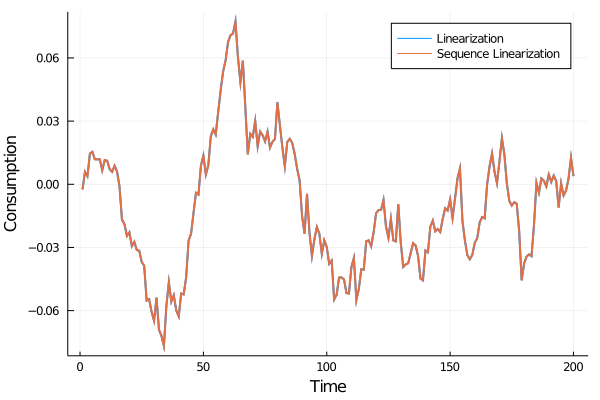

In [45]:
using Random
Random.seed!(21323)
df = simulate_RBC(model,200)
Random.seed!(21323)
df2 = simulate_RBC_sequence(model,200,100)
#Compare w/ same random seed
@df df  plot(:t,:c,label="Linearization",legend=true)
@df df2 plot!(:t,:c,label="Sequence Linearization",xlabel="Time",ylabel="Consumption")

# Dynare

## Higer Order and More
* Dynare is an incredibly useful toolkit for macoeconomics

* Primarily analysis is done through perturbation theory:
    * First order approximations
    * Second order approximations
    * etc.

* Written to be easy to modeler
    * just input your sytem of equations and go

* Once policy rules are computed can perform simulation and estimation as well


## The MOD File
* Building block of dynare is the .mod file
    * Allows you to specify your model and procedures you want to run

* I'll break break down our mod file into parameters
    * Dynare uses matlab so we'll call it through the MATLAB.jl package (need to install matlab)

## Declare Variables
```
var c k z r;
varexo e;
parameters bet del alp sig rho s;
bet = 0.96;
del = 0.1;
alp = 0.3;
sig = 2;
rho = 0.85;
s = 0.015;
```
* Note the semicolons

## Setup The Model
```
model;
(c)^(-sig)=bet*(c(+1)^(-sig)*r(+1));
k=exp(z)*k(-1)^alp-c+(1-del)*k(-1);
r = 1+alp*exp(z)*k(-1)^(alp-1)-del;
z = rho*z(-1)+s*e;
end;

shocks;
var e;
stderr 1;
end;
```
* Note (+1) means one period ahead
* (-1) denotes predetermined variables

## Describe What You Want To Do
```
initval;
k = 1;
c = 1;
z = 0;
e = 0;
end;

steady;

stoch_simul(order = 1, periods=1000);
```
* initval given the initial conditions for steady state
* can write your own code to find steady state

## Running the MOD File

In [49]:
using MATLAB
mat"cd 'Perturbation Theory'" #Mod file has to be in current directory
mat"dynare RBC.mod" #As easy as that

>> >> >> Using 64-bit preprocessor
Starting Dynare (version 4.6.4).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 4 equation(s).
Evaluating expressions...done
Computing static model derivatives (order 1).
Computing dynamic model derivatives (order 1).
Processing outputs ...
done
Preprocessing completed.


STEADY-STATE RESULTS:

c 		 1.08719
k 		 2.92082
z 		 0
r 		 1.04167

MODEL SUMMARY

  Number of variables:         4
  Number of stochastic shocks: 1
  Number of state variables:   2
  Number of jumpers:           2
  Number of static variables:  0


MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS
Variables           e
e            1.000000

POLICY AND TRANSITION FUNCTIONS
                                   c               k               z               r
Constant                    1.087195        2.920822               0        1.041667
k(-1)                       0.148354        0.893313               0       -0.033952
z(-1)                      

{Error using cd
Unable to change current folder to '/Users/dgevans/Dropbox/University of
Oregon/Courses/Spring 2022/EC 607 - Computational/Markdown
Lectures/Perturbation Theory/Perturbation Theory' (Name is nonexistent or not a
folder).
} 


## Compare To Our Linearization
* Can get variables from matlab `c_e` holds impulse response of consumption

In [50]:
c_dyn = @mget c_e;

* Compare IRF to our linearization

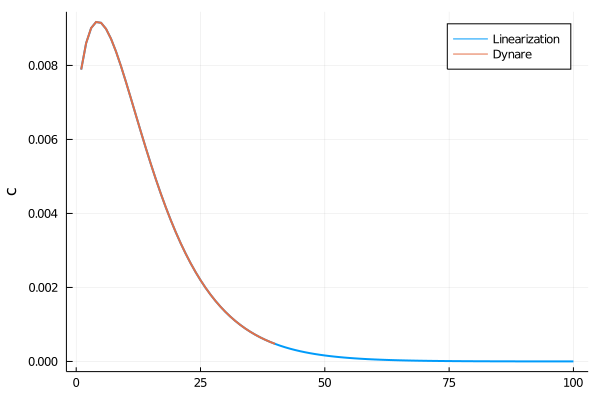

In [51]:
@df df_irf plot(:c,label="Linearization",legend=true)
plot!(c_dyn,label="Dynare",ylabel="c")

## Higher Order
* Can also do higher order approximations
```
initval;
k = 1;
c = 1;
z = 0;
e = 0;
end;

steady;

stoch_simul(order = 2, periods=1000);
```

In [53]:
mat"dynare RBC2.mod" #As easy as that

>> >> >> Using 64-bit preprocessor
Starting Dynare (version 4.6.4).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 4 equation(s).
Evaluating expressions...done
Computing static model derivatives (order 1).
Computing dynamic model derivatives (order 2).
Processing outputs ...
done
Preprocessing completed.


STEADY-STATE RESULTS:

c 		 1.08719
k 		 2.92082
z 		 0
r 		 1.04167

MODEL SUMMARY

  Number of variables:         4
  Number of stochastic shocks: 1
  Number of state variables:   2
  Number of jumpers:           2
  Number of static variables:  0


MATRIX OF COVARIANCE OF EXOGENOUS SHOCKS
Variables           e
e            1.000000

POLICY AND TRANSITION FUNCTIONS
                                   c               k               z               r
Constant                    1.086981        2.921036               0        1.041667
(correction)               -0.000214        0.000214               0               0
k(-1)                      

## Compare First and Second Order

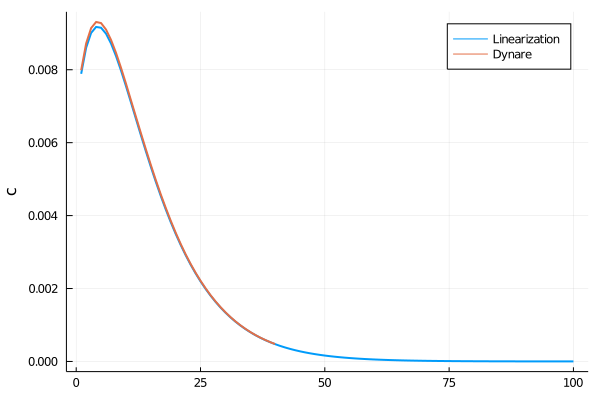

In [54]:
c_dyn = @mget c_e;
@df df_irf plot(:c,label="Linearization",legend=true)
plot!(c_dyn,label="Dynare",ylabel="c")